In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:

directory = 'coalition_XIV/'

files = os.listdir(directory)

dataframes = {}

for file in files:
    extension = os.path.splitext(file)[1]
    
    if extension == '.json':
        filepath = os.path.join(directory, file)
        df = pd.read_json(filepath)
    elif extension == '.parquet':
        filepath = os.path.join(directory, file)
        df = pd.read_parquet(filepath)
    else:
        continue
    
    dataframes[file] = df

categories_df = dataframes['categories.json']
votesMetadata_df = dataframes['votesMetadata.json']
links_df = dataframes['links.json']
votes_df = dataframes['votes.parquet']
voters_df = dataframes['voters.parquet']
metadata_df = dataframes['metadata.parquet']
sessionData_df = dataframes['sessionData.parquet']
votesMatrix_df = dataframes['votesMatrix.json']
nodes_df = dataframes['nodes.json']


In [3]:
votesMatrix_df = votesMatrix_df.replace({'POOLT': int(1), 'VASTU': -1, np.nan: 99, 'EI_HAALETANUD': 99, 'PUUDUB':99, 'ERAPOOLETU':0})

votesMatrix_df.head(2)


,6b45cfb5-8a17-481c-b674-80fc00c6cf5d,d8909ed8-ac93-4223-a3ec-55e1bb4ec8a9,fe748f4d-3f50-4af8-8069-92a460978d2b,9f3d840c-3a49-43de-8c5d-d1990933b692,7655e8d3-b658-49f0-8e09-f6cbc4a2c714,90074aa2-4938-41a9-8275-3a6efa1cee31,6f87ce5b-aad3-4118-9649-253cfd076b53,6eafafda-f117-44e5-b14b-1956d566e233,07132cc4-5afc-4edb-9537-7c721ec39b2d,f8a770b2-916c-4172-84b3-005ba9906a18,...,8d9daaeb-dbaf-4887-8311-881b29bedfa9,410c0030-7bcd-4977-85c2-27af3439770f,0f9372ee-f108-47f9-9192-82ff84cf3efb,ee639cdf-b86c-48b7-9b34-fbba9b83826d,576e5358-efd7-4993-8945-f5e9aad48856,c26f94dc-bc04-4c46-8f30-d8611f5854b0,1a537e56-0135-4981-a625-b4a53be86e3f,04510d7c-b12a-48aa-8402-80b0efb114a6,6e0b6122-249d-48f1-9582-9df8b2bb236d,988995d4-3cbe-4ea7-acdd-6222d0b658b1
0,1,1,1.0,1,1,1,1,1,1,1,...,99,99,99,99,99,99,99,99,99,99
1,1,1,1.0,1,1,1,1,1,1,1,...,99,99,99,99,99,99,99,99,99,99


In [4]:
unique_values = votesMatrix_df.values.flatten().tolist()
unique_values = set(unique_values) - {-1, 0, 1}

if len(unique_values) > 0:
    print("Other values found in votesMatrix_df:")
    print(unique_values)
else:
    print("No other values found in votesMatrix_df.")

Other values found in votesMatrix_df:
{99.0}


In [5]:
votes_transposed = votesMatrix_df.T

merged_df = voters_df[['factionId']].join(votes_transposed, how='inner')

faction_modes = merged_df.groupby('factionId').agg(lambda x: x.mode().iat[0])

In [6]:
votes_with_factionID = votes_transposed.merge(voters_df, left_index=True, right_index=True)


In [7]:
scores = []

for index, row in votes_with_factionID.iterrows():
    faction_mode_row = faction_modes.loc[row['factionId']]
    score = 0
    
    for i in range(0, 1866):
        if row[i] == 99:
            score += 0
        elif faction_mode_row[i] == 99:
            score += 0
        elif row[i] != faction_mode_row[i]:
            score += 1
            
    scores.append(score)
    
votes_with_factionID['score'] = scores


In [8]:
votes_with_factionID['vote_count'] = (votes_with_factionID != 99).sum(axis=1)


In [9]:
votes_with_factionID['normalized_score'] = votes_with_factionID['score'] / votes_with_factionID['vote_count']


In [20]:
votes_with_factionID = votes_with_factionID[votes_with_factionID['vote_count'] >= 200]

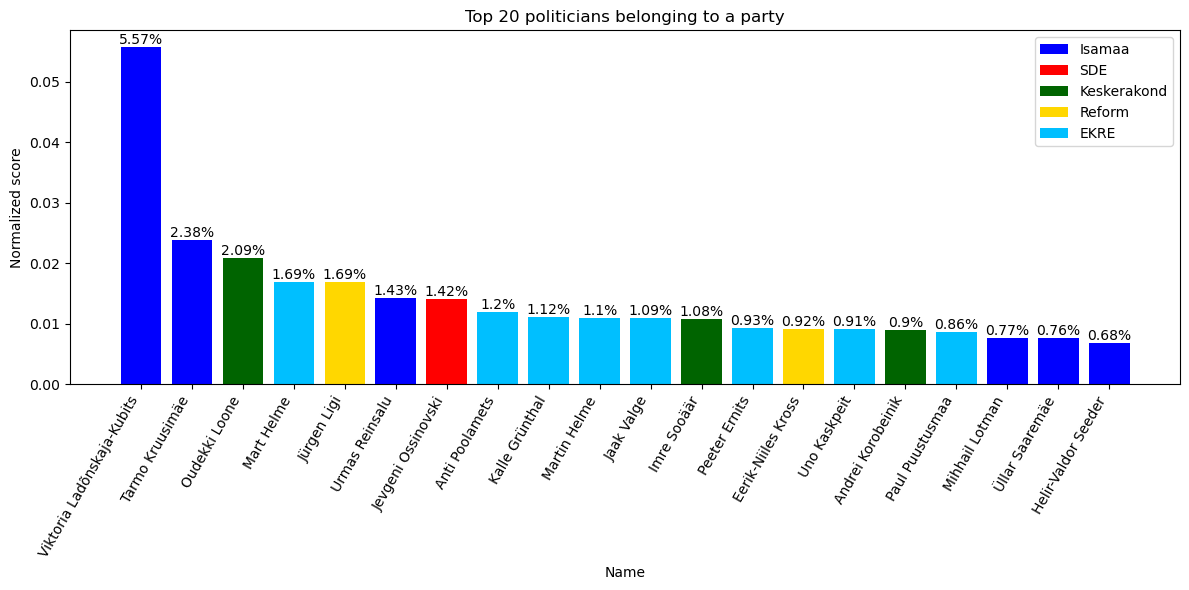

In [33]:

filtered_scores = votes_with_factionID[votes_with_factionID['factionId'] != 'c99e4e31-617c-49ad-bfa6-814736842182']

highest_scores = filtered_scores.nlargest(20, 'normalized_score')

colors = {'a844d128-287d-4c20-bf30-61fcb0af23cf': 'blue',
          'd188e268-5d01-7e93-0c22-3ae7f0c1e851': 'red',
          '3c1832c0-7727-18d1-d9d3-e685a58f44b0': 'darkgreen',
          '8772fd6f-3197-6a53-2ffc-8c4d63407d1e': 'gold',
          'd4e90963-1d10-4f8a-bf37-a99ca8531ff3': 'deepskyblue'}

plt.figure(figsize=(12, 6))

highest_scores = highest_scores.sort_values('normalized_score', ascending=False)

highest_scores = highest_scores.sort_values('normalized_score', ascending=False)

bars = plt.bar(highest_scores['name'], highest_scores['normalized_score'], color=[colors[factionId] for factionId in highest_scores['factionId']])

for i, bar in enumerate(bars):
    percentage = round(bar.get_height() * 100, 2)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage}%",
             ha='center', va='bottom')

plt.xticks(rotation=60, ha='right')

plt.xlabel('Name')
plt.ylabel('Normalized score')
plt.title('Top 20 politicians belonging to a party')

legend_labels = ['Isamaa', 'SDE', 'Keskerakond', 'Reform', 'EKRE']
legend_handles = [plt.bar([0], [0], color=colors[factionId])[0] for factionId in colors]
plt.legend(legend_handles, legend_labels, loc='upper right')

plt.tight_layout()
plt.show()


In [22]:
faction1_scores = votes_with_factionID[votes_with_factionID['factionId'] == '3c1832c0-7727-18d1-d9d3-e685a58f44b0'].nlargest(5, 'normalized_score')
faction2_scores = votes_with_factionID[votes_with_factionID['factionId'] == '8772fd6f-3197-6a53-2ffc-8c4d63407d1e'].nlargest(5, 'normalized_score')
faction3_scores = votes_with_factionID[votes_with_factionID['factionId'] == 'a844d128-287d-4c20-bf30-61fcb0af23cf'].nlargest(5, 'normalized_score')
faction4_scores = votes_with_factionID[votes_with_factionID['factionId'] == 'c99e4e31-617c-49ad-bfa6-814736842182'].nlargest(5, 'normalized_score')
faction5_scores = votes_with_factionID[votes_with_factionID['factionId'] == 'd188e268-5d01-7e93-0c22-3ae7f0c1e851'].nlargest(5, 'normalized_score')
faction6_scores = votes_with_factionID[votes_with_factionID['factionId'] == 'd4e90963-1d10-4f8a-bf37-a99ca8531ff3'].nlargest(5, 'normalized_score')




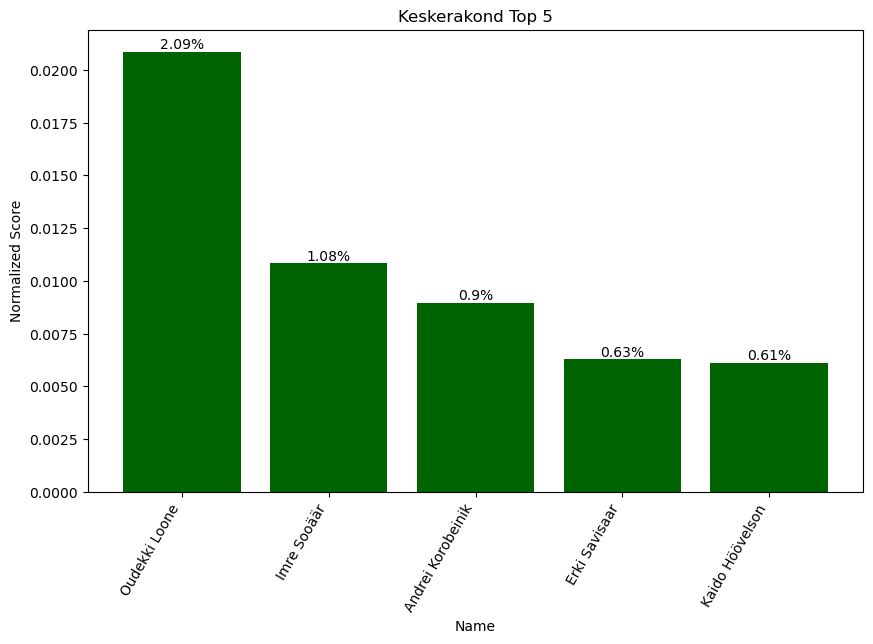

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(faction1_scores['name'], faction1_scores['normalized_score'], color='darkgreen')
plt.xticks(rotation=60, ha='right')
for i, score in enumerate(faction1_scores['normalized_score']):
    percentage = round(score * 100, 2)
    plt.text(i, score, f"{percentage}%", ha='center', va='bottom')
plt.xlabel('Name')
plt.ylabel('Normalized Score')
plt.title('Keskerakond Top 5')
plt.show()


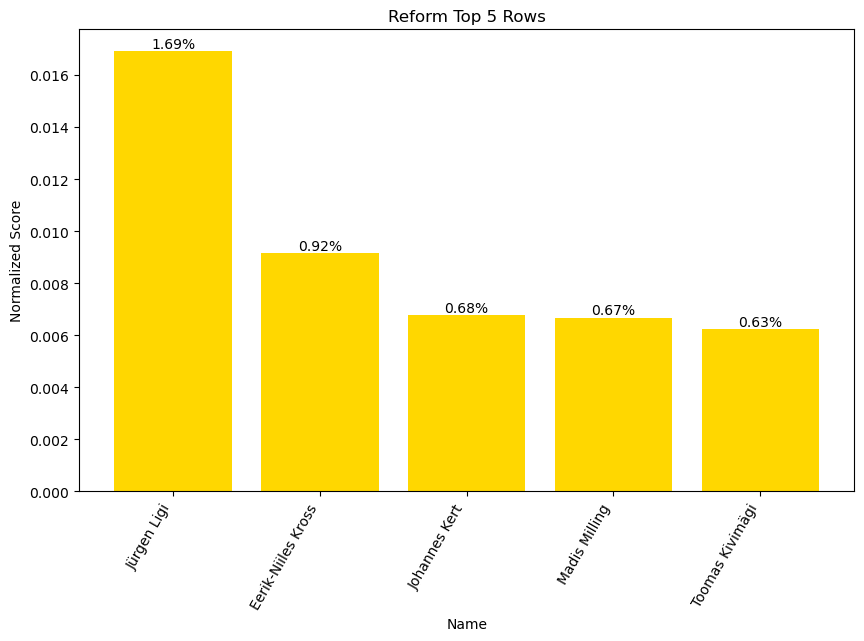

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(faction2_scores['name'], faction2_scores['normalized_score'], color='gold')
plt.xticks(rotation=60, ha='right')
for i, score in enumerate(faction2_scores['normalized_score']):
    percentage = round(score * 100, 2)
    plt.text(i, score, f"{percentage}%", ha='center', va='bottom')
plt.xlabel('Name')
plt.ylabel('Normalized Score')
plt.title('Reform Top 5 Rows')
plt.show()

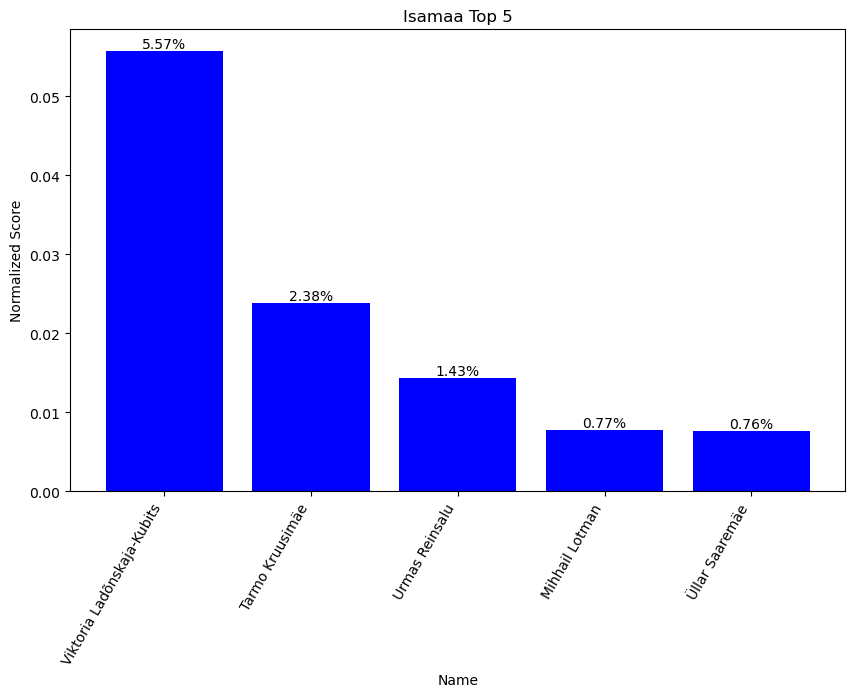

In [38]:

plt.figure(figsize=(10, 6))
plt.bar(faction3_scores['name'], faction3_scores['normalized_score'], color='blue')
plt.xticks(rotation=60, ha='right')
for i, score in enumerate(faction3_scores['normalized_score']):
    percentage = round(score * 100, 2)
    plt.text(i, score, f"{percentage}%", ha='center', va='bottom')
plt.xlabel('Name')
plt.ylabel('Normalized Score')
plt.title('Isamaa Top 5')
plt.show()

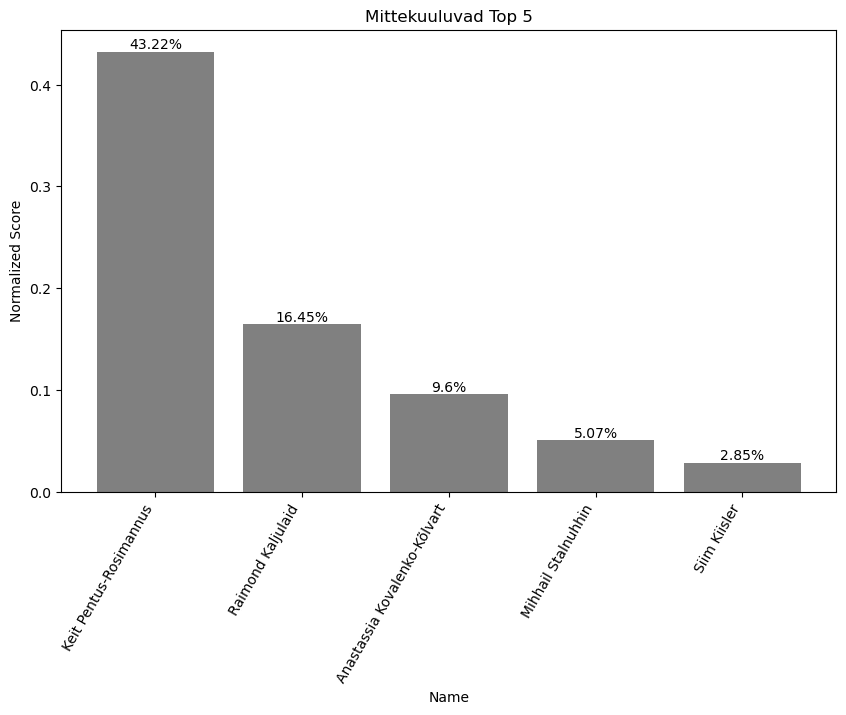

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(faction4_scores['name'], faction4_scores['normalized_score'], color='grey')
plt.xticks(rotation=60, ha='right')
for i, score in enumerate(faction4_scores['normalized_score']):
    percentage = round(score * 100, 2)
    plt.text(i, score, f"{percentage}%", ha='center', va='bottom')
plt.xlabel('Name')
plt.ylabel('Normalized Score')
plt.title('Mittekuuluvad Top 5')
plt.show()

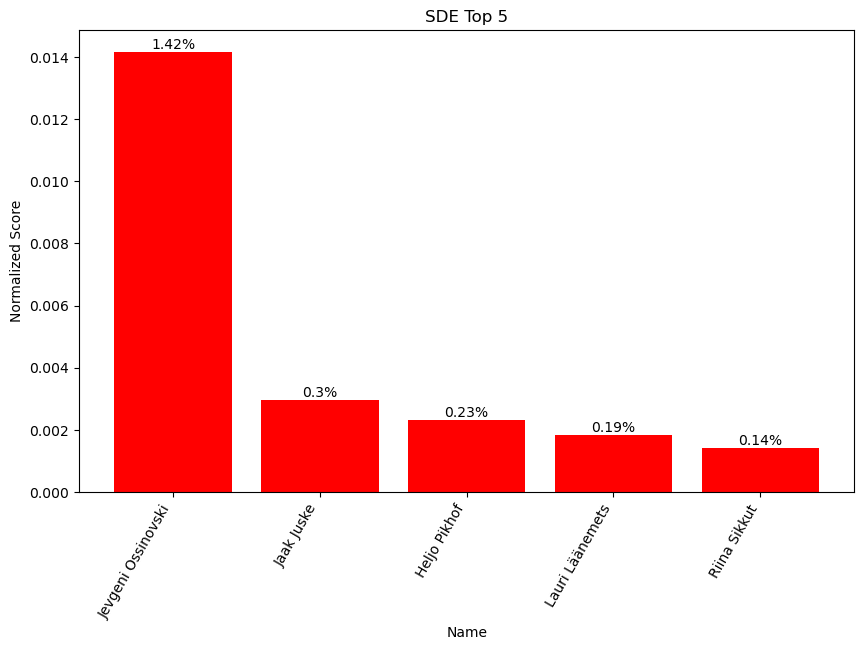

In [42]:
plt.figure(figsize=(10, 6))
plt.bar(faction5_scores['name'], faction5_scores['normalized_score'], color='red')
plt.xticks(rotation=60, ha='right')
for i, score in enumerate(faction5_scores['normalized_score']):
    percentage = round(score * 100, 2)
    plt.text(i, score, f"{percentage}%", ha='center', va='bottom')
plt.xlabel('Name')
plt.ylabel('Normalized Score')
plt.title('SDE Top 5')
plt.show()

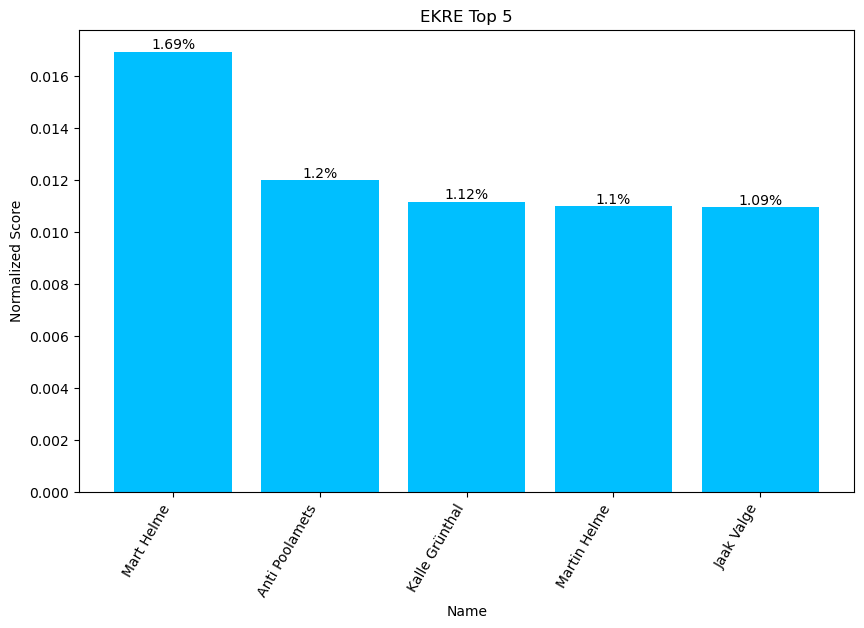

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(faction6_scores['name'], faction6_scores['normalized_score'], color='deepskyblue')
plt.xticks(rotation=60, ha='right')
for i, score in enumerate(faction6_scores['normalized_score']):
    percentage = round(score * 100, 2)
    plt.text(i, score, f"{percentage}%", ha='center', va='bottom')
plt.xlabel('Name')
plt.ylabel('Normalized Score')
plt.title('EKRE Top 5')
plt.show()